In [7]:
import numpy as np
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [2]:
train_folder = r'C:\Users\User\Desktop\codes\fer2013\1\train'

In [3]:
class_names = os.listdir(train_folder)
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [4]:
X_train = []
X_test = []
y_train = []
y_test = []

In [5]:
for label, i in enumerate(class_names):
    file_path = os.path.join(train_folder, i)
    for img in os.listdir(file_path):
        image_arr = cv2.imread(os.path.join(file_path, img), cv2.IMREAD_GRAYSCALE)
        X_train.append(image_arr)
        y_train.append(label)


In [6]:
X_train = np.array(X_train)

print(X_train.shape)

(28709, 48, 48)


(-0.5, 47.5, 47.5, -0.5)

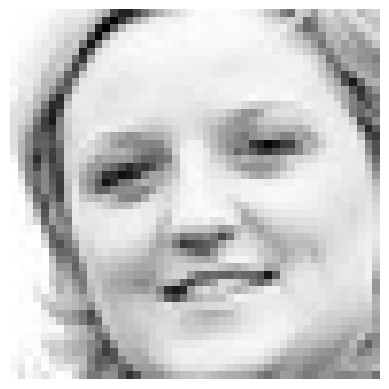

In [12]:
plt.imshow(X_train[10000], cmap= 'gray')
plt.axis('off')

In [7]:
test_folder = r'C:\Users\User\Desktop\codes\fer2013\1\test'

In [8]:
for label, i in enumerate(class_names):
    file_path = os.path.join(test_folder, i)
    for img in os.listdir(file_path):
        image_arr = cv2.imread(os.path.join(file_path, img), cv2.IMREAD_GRAYSCALE)
        X_test.append(image_arr)
        y_test.append(label)

In [9]:
X_test = np.array(X_test)

print(X_test.shape)

(7178, 48, 48)


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
X_train = torch.tensor(X_train, dtype= torch.float32, device= device)
X_test = torch.tensor(X_test, dtype= torch.float32, device= device)

In [12]:
X_train = X_train.reshape((-1, 48, 48, 1))/255.0
X_test = X_test.reshape((-1, 48, 48, 1))/255.0

In [13]:
X_train = X_train.permute(0, 3, 1, 2)  # [N, H, W, C] → [N, C, H, W]
X_test  = X_test.permute(0, 3, 1, 2)


In [14]:
print(X_train.shape)  
print(X_test.shape) 

torch.Size([28709, 1, 48, 48])
torch.Size([7178, 1, 48, 48])


In [15]:
y_train = torch.tensor(y_train, dtype= torch.long)
y_test = torch.tensor(y_test, dtype= torch.long)

In [16]:
print(y_test.shape)

torch.Size([7178])


In [17]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size= 64, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size= 64, shuffle= True)

# Definition of architecture

In [20]:
class EmotionCNN(nn.Module):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Block 1
        self.conv1_1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(32)
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(0.25)

        # Block 2
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(64)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout(0.25)

        # Block 3
        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(128)
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.drop3 = nn.Dropout(0.25)

        # Block 4
        self.conv4_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(256)
        self.conv4_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.drop4 = nn.Dropout(0.25)

        # Fully Connected
        self.fc1 = nn.Linear(256 * 3 * 3, 512)  
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.drop_fc1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.drop_fc2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(256, 7)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = self.pool1(x)
        x = self.drop1(x)

        # Block 2
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = self.pool2(x)
        x = self.drop2(x)

        # Block 3
        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = self.pool3(x)
        x = self.drop3(x)

        # Block 4
        x = F.relu(self.bn4_1(self.conv4_1(x)))
        x = F.relu(self.bn4_2(self.conv4_2(x)))
        x = self.pool4(x)
        x = self.drop4(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully Connected
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.drop_fc1(x)

        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.drop_fc2(x)

        x = self.fc3(x)  
        return x


In [21]:
model = EmotionCNN().to(device)

# Training section

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [23]:
num_epochs = 100
for epoch in range(num_epochs):

    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Loss: {total_loss:.4f}, Train Acc: {train_acc:.2f}%")

    # Evaluation 
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_acc = 100 * correct_test / total_test
    print(f"Test Accuracy: {test_acc:.2f}%")

Epoch [1/100] Loss: 737.0035, Train Acc: 35.04%
Test Accuracy: 44.30%
Epoch [2/100] Loss: 598.2986, Train Acc: 49.03%
Test Accuracy: 50.43%
Epoch [3/100] Loss: 556.4056, Train Acc: 53.23%
Test Accuracy: 55.31%
Epoch [4/100] Loss: 527.3971, Train Acc: 55.47%
Test Accuracy: 57.01%
Epoch [5/100] Loss: 504.0984, Train Acc: 57.74%
Test Accuracy: 58.39%
Epoch [6/100] Loss: 485.0518, Train Acc: 59.37%
Test Accuracy: 59.58%
Epoch [7/100] Loss: 468.9902, Train Acc: 60.98%
Test Accuracy: 59.52%
Epoch [8/100] Loss: 451.6637, Train Acc: 62.61%
Test Accuracy: 61.44%
Epoch [9/100] Loss: 437.2802, Train Acc: 63.52%
Test Accuracy: 61.84%
Epoch [10/100] Loss: 422.5947, Train Acc: 64.68%
Test Accuracy: 62.36%
Epoch [11/100] Loss: 408.4267, Train Acc: 66.35%
Test Accuracy: 63.60%
Epoch [12/100] Loss: 394.3644, Train Acc: 67.29%
Test Accuracy: 64.89%
Epoch [13/100] Loss: 378.0326, Train Acc: 68.71%
Test Accuracy: 64.13%
Epoch [14/100] Loss: 363.2866, Train Acc: 69.89%
Test Accuracy: 64.41%
Epoch [15/100] 